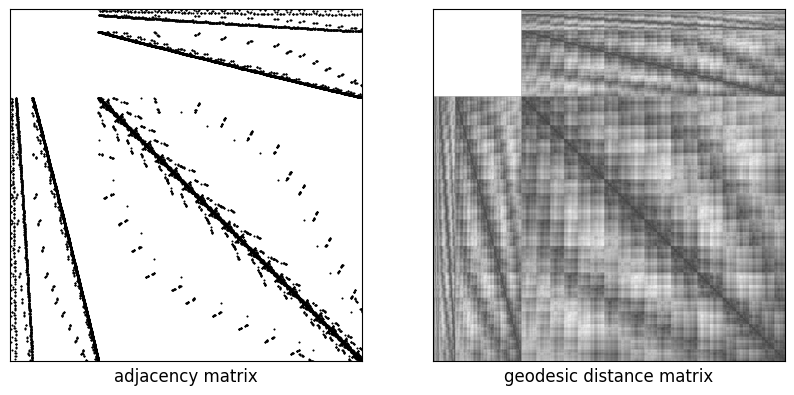

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import utils
from IPython.display import clear_output
from joblib import Parallel, delayed
from lapy import Solver, TriaMesh
from lapy.diffgeo import compute_geodesic_f
from nilearn import datasets, plotting, surface
from sksparse.cholmod import cholesky

# set notebook defaults
rng = np.random.default_rng(seed=0)
plt.rcParams["font.size"] = 12

# freesurfer pial left mesh
fsaverage = datasets.fetch_surf_fsaverage(mesh="fsaverage4")
surface_mesh = surface.load_surf_mesh(fsaverage["pial_left"])
n_vertices = surface_mesh.coordinates.shape[0]

# lapy objects
mesh = TriaMesh(v=surface_mesh.coordinates, t=surface_mesh.faces)
fem = Solver(mesh, lump=True, use_cholmod=True)

# calculate adjacency matrix
A = utils.adjacency_matrix(surface_mesh)


# calculate geodesic distance matrix
@delayed
def geodesic_dist(vertex):
    """geodesic distance matrix"""
    t = mesh.avg_edge_length() ** 2
    backward_matrix = fem.mass + t * fem.stiffness
    factor = cholesky(backward_matrix)
    b0 = np.zeros(n_vertices)
    b0[vertex] = 1
    u = factor(b0)
    return compute_geodesic_f(mesh, u)


with Parallel(n_jobs=-2) as parallel:
    D = np.column_stack(parallel(geodesic_dist(vertex) for vertex in range(n_vertices)))
    D[:642, :642] = np.nan  # medial wall
    clear_output()


# plot adjacency and geodesic distance matrices
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
axs[0].spy(A, ms=0.5, c="k")
axs[0].set_xlabel("adjacency matrix")
axs[1].imshow(D, cmap="binary_r", alpha=0.75)
axs[1].set_xlabel("geodesic distance matrix")
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

Solver: Cholesky decomposition from scikit-sparse cholmod ...


[<Figure size 1500x400 with 5 Axes>,
 <Figure size 1500x400 with 5 Axes>,
 <Figure size 1500x400 with 5 Axes>,
 <Figure size 1500x400 with 5 Axes>,
 <Figure size 1500x400 with 5 Axes>]

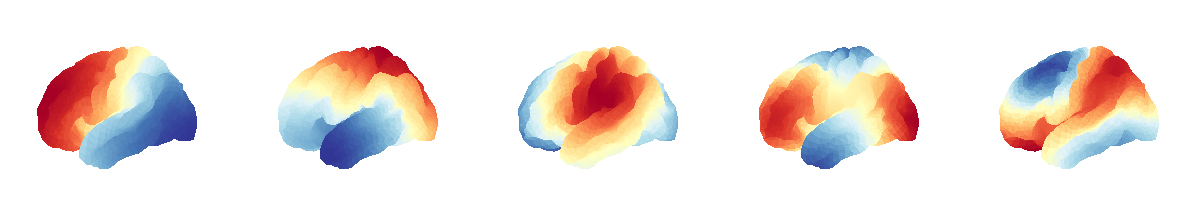

In [2]:
# laplace-beltrami eigenmodes
n_modes = 1000
evals, emodes = utils.lb_emodes(fem, n_modes)

# plot first five eigenmodes
n_cols = 5
fig, axs = plt.subplots(ncols=n_cols, figsize=(15, 4), subplot_kw=dict(projection="3d"))
[plotting.plot_surf(surf_mesh=surface_mesh, surf_map=emodes[:, i], axes=axs[i], cmap="RdYlBu_r") for i in range(n_cols)]

[<Figure size 1500x400 with 5 Axes>,
 <Figure size 1500x400 with 5 Axes>,
 <Figure size 1500x400 with 5 Axes>,
 <Figure size 1500x400 with 5 Axes>,
 <Figure size 1500x400 with 5 Axes>]

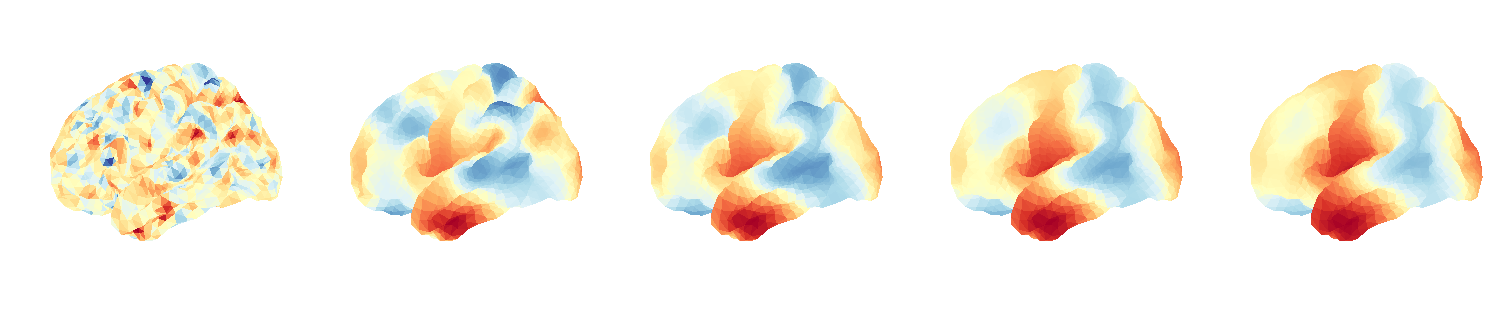

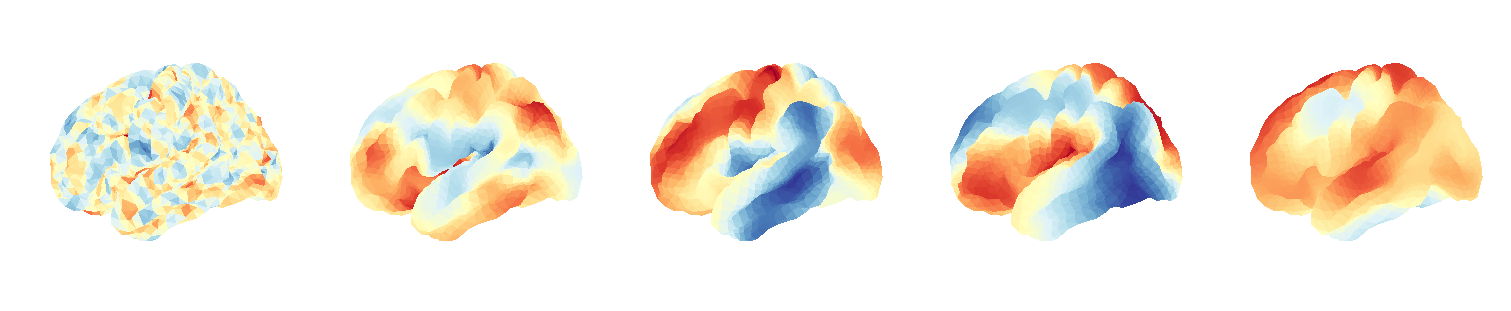

In [3]:
# generate five GRFs with increasing autocorrelation, heat kernel vs iterative methods
sigmas = np.linspace(0, 500, n_cols)
fig, axs = plt.subplots(ncols=n_cols, figsize=(15, 4), subplot_kw=dict(projection="3d"), layout="constrained")
[
    plotting.plot_surf(
        surf_mesh=surface_mesh,
        surf_map=utils.heat_kernel_smoothing(evals, emodes, sigma=sigmas[i]),
        axes=axs[i],
        cmap="RdYlBu_r",
    )
    for i in range(n_cols)
]


iterations = np.linspace(1, 100, n_cols)
fig, axs = plt.subplots(ncols=n_cols, figsize=(15, 4), subplot_kw=dict(projection="3d"), layout="constrained")
[
    plotting.plot_surf(
        surf_mesh=surface_mesh,
        surf_map=utils.iterative_smoothing(
            surface_mesh, rng.standard_normal(size=n_vertices), iterations=int(iterations[i])
        ),
        axes=axs[i],
        cmap="RdYlBu_r",
    )
    for i in range(n_cols)
]

In [4]:
# !! 30 sec runtime !!

# simulation setting
sigma, n_repeats = 5, 1000


@delayed
def run_simulation(repeat):
    rng = np.random.default_rng(seed=repeat)
    grf_heat = utils.heat_kernel_smoothing(evals, emodes, sigma=sigma, seed=repeat)
    grf_iter = utils.iterative_smoothing(surface_mesh, rng.standard_normal(size=n_vertices), iterations=2)
    _, acf_heat = utils.acf(grf_heat, D)
    _, acf_iter = utils.acf(grf_iter, D)
    return acf_heat, acf_iter


with Parallel(n_jobs=-2) as parallel:
    acfs = parallel(run_simulation(repeat) for repeat in range(n_repeats))
    acfs_heat, acfs_iter = map(np.asarray, zip(*acfs))

/Users/griegner/git-repositories/dsc190/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Text(0, 0.5, 'Correlation')

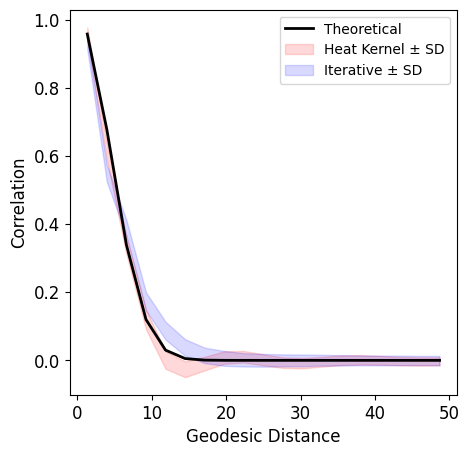

In [5]:
# theoretical
grf = utils.heat_kernel_smoothing(evals, emodes, sigma=sigma)
dist, _ = utils.acf(grf, D)
acf = utils.heat_kernel(dist, 2 * sigma)

# heat kernel
mean_heat = acfs_heat.mean(axis=0)
std_heat = acfs_heat.std(axis=0)

# iterative
mean_iter = acfs_iter.mean(axis=0)
std_iter = acfs_iter.std(axis=0)


fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(dist, acf, lw=2, c="k", label="Theoretical")
ax.fill_between(dist, mean_heat - std_heat, mean_heat + std_heat, color="red", alpha=0.15, label="Heat Kernel ± SD")
ax.fill_between(dist, mean_iter - std_iter, mean_iter + std_iter, color="blue", alpha=0.15, label="Iterative ± SD")
ax.legend(fontsize=10)
ax.set_xlabel("Geodesic Distance")
ax.set_ylabel("Correlation")